In [207]:
import numpy as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
%matplotlib inline

In [208]:
from __future__ import print_function

import keras
from keras import metrics
from keras.datasets import mnist
from keras.models import Sequential
from keras.optimizers import RMSprop, SGD
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from keras.layers import Conv3D, MaxPooling3D, LeakyReLU

In [209]:
"""
Returns the tau's to be predicted
"""
def get_output_data():
    tau_11 = loadmat('tau11_xyz_T1.mat')['tau11']
    tau_12 = loadmat('tau12_xyz_T1.mat')['tau12']
    tau_13 = loadmat('tau13_xyz_T1.mat')['tau13']
    tau_22 = loadmat('tau22_xyz_T1.mat')['tau22']
    tau_23 = loadmat('tau23_xyz_T1.mat')['tau23']
    tau_33 = loadmat('tau33_xyz_T1.mat')['tau33']
    return tau_11, tau_12, tau_13, tau_22, tau_23, tau_33

In [210]:
"""
Returns the heat's to be predicted
"""
def get_output_data_heat():
    heat_1 = loadmat('Heat1_xyz_T1.mat')['Heat1']
    heat_2 = loadmat('Heat2_xyz_T1.mat')['Heat2']
    heat_3 = loadmat('Heat3_xyz_T1.mat')['Heat3']
    return heat_1, heat_2, heat_3

In [211]:
"""
Returns the tau's to be predicted
"""
def get_input_data_heat():
    uf = loadmat('u_F_xyz_T1.mat')['u_F']
    vf = loadmat('v_F_xyz_T1.mat')['v_F']
    wf = loadmat('w_F_xyz_T1.mat')['w_F']
    theta = loadmat('theta_F_xyz_T1.mat')['theta_F']
    grad = loadmat('grad_Tz_F_xyz_T1.mat')['grad_T_z']
    return uf, vf, wf, theta, grad

In [212]:
"""
Returns the tau's to be predicted
"""
def get_input_data():
    uf = loadmat('u_F_xyz_T1.mat')['u_F']
    vf = loadmat('v_F_xyz_T1.mat')['v_F']
    wf = loadmat('w_F_xyz_T1.mat')['w_F']
    tke = loadmat('TKE_F_xyz_T1.mat')['TKE_F']
    return uf, vf, wf, tke

In [213]:
"""
Explores Dataset
"""
def explore_data(data):
    plt.figure(figsize=(15,5))
    # Varying by X
    plt.subplot(1,3,1)
    plt.plot(data[:,0,0])
    # Varying by Y
    plt.subplot(1,3,2)
    plt.plot(data[0,:,0])
    # Varying by Z
    plt.subplot(1,3,3)
    plt.plot(data[0,0,:])
    plt.show()

In [214]:
"""
Denormalizes Outputs
"""
def denormalize_data(train, test):
    mu, std = np.mean(train.flatten()), np.std(train.flatten())
    train_new = (train - mu)/std
    test_new = (test - mu)/std
    print()
    return train_new, test_new, mu, std

In [215]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                           uf, vf, wf, tke,
                           train_pct, size = 1):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), tke.flatten()]))
    
    tau_11_dataset = np.transpose(np.array([tau_11.flatten()]))
    tau_12_dataset = np.transpose(np.array([tau_12.flatten()]))
    tau_13_dataset = np.transpose(np.array([tau_13.flatten()]))
    tau_22_dataset = np.transpose(np.array([tau_22.flatten()]))
    tau_23_dataset = np.transpose(np.array([tau_23.flatten()]))
    tau_33_dataset = np.transpose(np.array([tau_33.flatten()]))

    print(x_dataset.shape)
    print(tau_11_dataset.shape, tau_12_dataset.shape, tau_13_dataset.shape,
          tau_22_dataset.shape, tau_23_dataset.shape, tau_33_dataset.shape)

    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    tau_11_train, tau_11_test = tau_11_dataset[train_test_index,:], tau_11_dataset[~train_test_index,:]
    tau_12_train, tau_12_test = tau_12_dataset[train_test_index,:], tau_12_dataset[~train_test_index,:]
    tau_13_train, tau_13_test = tau_13_dataset[train_test_index,:], tau_13_dataset[~train_test_index,:]
    tau_22_train, tau_22_test = tau_22_dataset[train_test_index,:], tau_22_dataset[~train_test_index,:]
    tau_23_train, tau_23_test = tau_23_dataset[train_test_index,:], tau_23_dataset[~train_test_index,:]
    tau_33_train, tau_33_test = tau_33_dataset[train_test_index,:], tau_33_dataset[~train_test_index,:]
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [216]:
"""
Reshapes Data and split data into train and test sets
"""
def create_train_test_sets_heat(heat_1, heat_2, heat_3,
                                uf, vf, wf, theta, grad,
                                train_pct, size = 1):
    
    x_dataset = np.transpose(np.array([uf.flatten(), vf.flatten(), wf.flatten(), theta.flatten(), grad.flatten()]))
    
    heat_1_dataset = np.transpose(np.array([heat_1.flatten()]))
    heat_2_dataset = np.transpose(np.array([heat_2.flatten()]))
    heat_3_dataset = np.transpose(np.array([heat_3.flatten()]))

    print(x_dataset.shape)
    print(heat_1_dataset.shape, heat_2_dataset.shape, heat_3_dataset.shape)
    
    train_test_index = (np.random.rand(x_dataset.shape[0]) < train_pct)

    x_train, x_test = x_dataset[train_test_index,:], x_dataset[~train_test_index,:]
    x_normalized = [denormalize_data(x_train[:,k], x_test[:,k]) for k in range(x_train.shape[1])]
    x_train = np.transpose(np.array([k[0] for k in x_normalized]))
    x_test = np.transpose(np.array([k[1] for k in x_normalized]))
    
    print(x_train.shape)
    print(x_test.shape)

    heat_1_train, heat_1_test = heat_1_dataset[train_test_index,:], heat_1_dataset[~train_test_index,:]
    heat_2_train, heat_2_test = heat_2_dataset[train_test_index,:], heat_2_dataset[~train_test_index,:]
    heat_3_train, heat_3_test = heat_3_dataset[train_test_index,:], heat_3_dataset[~train_test_index,:]
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)

    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test,
            heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [299]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d(tau_11, tau_12, tau_13, tau_22, tau_23, tau_33,
                                  uf, vf, wf, tke,
                                  train_pct, size = 3, augmentation = False):
    
    train_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*train_pct)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-train_pct))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    print(train_index.shape)
    
    test_index = ~(train_index)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    tau_11_train, tau_11_test = np.transpose([tau_11[train_locs]]), np.transpose([tau_11[test_locs]])
    tau_12_train, tau_12_test = np.transpose([tau_12[train_locs]]), np.transpose([tau_12[test_locs]])
    tau_13_train, tau_13_test = np.transpose([tau_13[train_locs]]), np.transpose([tau_13[test_locs]])
    tau_22_train, tau_22_test = np.transpose([tau_22[train_locs]]), np.transpose([tau_22[test_locs]])
    tau_23_train, tau_23_test = np.transpose([tau_23[train_locs]]), np.transpose([tau_23[test_locs]])
    tau_33_train, tau_33_test = np.transpose([tau_33[train_locs]]), np.transpose([tau_33[test_locs]])
    
    tau_11_train, tau_11_test, mu_11, std_11 = denormalize_data(tau_11_train, tau_11_test)
    tau_12_train, tau_12_test, mu_12, std_12 = denormalize_data(tau_12_train, tau_12_test)
    tau_13_train, tau_13_test, mu_13, std_13 = denormalize_data(tau_13_train, tau_13_test)
    tau_22_train, tau_22_test, mu_22, std_22 = denormalize_data(tau_22_train, tau_22_test)
    tau_23_train, tau_23_test, mu_23, std_23 = denormalize_data(tau_23_train, tau_23_test)
    tau_33_train, tau_33_test, mu_33, std_33 = denormalize_data(tau_33_train, tau_33_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 tke[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    if augmentation:
        axes = ((0,1),(0,2),(1,2))
        
        rotations_train = np.random.randint(0, 4, size = (x_train.shape[0], 3))
        axes_train = np.random.randint(0, 3, size = (x_train.shape[0], 3))
        x_train_new = np.array([np.stack([np.rot90(x_train[i,:,:,:,0], rotations_train[i,0], axes[axes_train[i,0]]),
                                          np.rot90(x_train[i,:,:,:,1], rotations_train[i,1], axes[axes_train[i,1]]),
                                          np.rot90(x_train[i,:,:,:,2], rotations_train[i,2], axes[axes_train[i,2]]),
                                          x_train[i,:,:,:,3]],
                                        axis = 3)
                                for i in range(x_train.shape[0])])
        print(x_train_new.shape)
        
        x_train = np.concatenate([x_train, x_train_new], axis = 0)
        
        tau_11_train = np.tile(tau_11_train, (2,1))
        tau_12_train = np.tile(tau_12_train, (2,1))
        tau_13_train = np.tile(tau_13_train, (2,1))
        tau_22_train = np.tile(tau_22_train, (2,1))
        tau_23_train = np.tile(tau_23_train, (2,1))
        tau_33_train = np.tile(tau_33_train, (2,1))
        
    
    print('X_train shape', x_train.shape)
    print('tau_train shape', tau_11_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, tau_11_train, tau_11_test, tau_12_train, tau_12_test, tau_13_train, tau_13_test,
           tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
           mu_11, std_11, mu_12, std_12, mu_13, std_13, mu_22, std_22, mu_23, std_23, mu_33, std_33)

In [309]:
"""
Reshapes Data and split data into train and test sets (Convolutional Set up)
"""
def create_train_test_sets_conv3d_heat(heat_1, heat_2, heat_3,
                                       uf, vf, wf, theta, grad,
                                       train_pct, size = 3, augmentation = False):
    
    train_index = np.concatenate((np.ones((int(np.floor(uf.shape[0]*train_pct)), uf.shape[1], uf.shape[2]), dtype = 'bool'),
                           np.zeros((int(np.ceil(uf.shape[0]*(1-train_pct))), uf.shape[1], uf.shape[2]), dtype = 'bool')),
                           axis = 0)
    
    print(train_index.shape)
    
    test_index = ~(train_index)
    
    offset_size = int(size/2)
    
    train_index[0:(0+offset_size),:,:] = False
    train_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    train_index[:,0:(0+offset_size),:] = False
    train_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    train_index[:,:,0:(0+offset_size)] = False
    train_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    test_index[0:(0+offset_size),:,:] = False
    test_index[(uf.shape[0]-offset_size):(uf.shape[0]),:,:] = False
    test_index[:,0:(0+offset_size),:] = False
    test_index[:,(uf.shape[1]-offset_size):(uf.shape[1]),:] = False
    test_index[:,:,0:(0+offset_size)] = False
    test_index[:,:,(uf.shape[2]-offset_size):(uf.shape[2])] = False
    
    train_locs = np.where(train_index)
    test_locs = np.where(test_index)
    
    print(train_locs)
    
    heat_1_train, heat_1_test = np.transpose([heat_1[train_locs]]), np.transpose([heat_1[test_locs]])
    heat_2_train, heat_2_test = np.transpose([heat_2[train_locs]]), np.transpose([heat_2[test_locs]])
    heat_3_train, heat_3_test = np.transpose([heat_3[train_locs]]), np.transpose([heat_3[test_locs]])
    
    heat_1_train, heat_1_test, mu_1, std_1 = denormalize_data(heat_1_train, heat_1_test)
    heat_2_train, heat_2_test, mu_2, std_2 = denormalize_data(heat_2_train, heat_2_test)
    heat_3_train, heat_3_test, mu_3, std_3 = denormalize_data(heat_3_train, heat_3_test)
    
    x_train = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  vf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  wf[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                  grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                 ], 
                                 axis = 3)
              for x,y,z in zip(train_locs[0], train_locs[1], train_locs[2])])

    x_test = np.array([np.stack([uf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 vf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 wf[(x-offset_size):(x+offset_size+1),
                                    (y-offset_size):(y+offset_size+1),
                                    (z-offset_size):(z+offset_size+1)],
                                 theta[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)],
                                 grad[(x-offset_size):(x+offset_size+1),
                                     (y-offset_size):(y+offset_size+1),
                                     (z-offset_size):(z+offset_size+1)]
                                ], 
                                axis = 3)
              for x,y,z in zip(test_locs[0], test_locs[1], test_locs[2])])
    
    print(x_test.shape)
    
    x_normalized = [denormalize_data(x_train[:,:,:,:,k], x_test[:,:,:,:,k]) for k in range(x_train.shape[4])]
    x_train = np.array(np.stack([k[0] for k in x_normalized], axis = 4))
    x_test = np.array(np.stack([k[1] for k in x_normalized], axis = 4))
    
    if augmentation:
        axes = ((0,1),(0,2),(1,2))
        
        rotations_train = np.random.randint(0, 4, size = (x_train.shape[0], 3))
        axes_train = np.random.randint(0, 3, size = (x_train.shape[0], 3))
        x_train_new = np.array([np.stack([np.rot90(x_train[i,:,:,:,0], rotations_train[i,0], axes[axes_train[i,0]]),
                                          np.rot90(x_train[i,:,:,:,1], rotations_train[i,1], axes[axes_train[i,1]]),
                                          np.rot90(x_train[i,:,:,:,2], rotations_train[i,2], axes[axes_train[i,2]]),
                                          x_train[i,:,:,:,3],
                                          x_train[i,:,:,:,4]],
                                        axis = 3)
                                for i in range(x_train.shape[0])])
        print(x_train_new.shape)
        
        x_train = np.concatenate([x_train, x_train_new], axis = 0)
        
        heat_1_train = np.tile(heat_1_train, (2,1))
        heat_2_train = np.tile(heat_2_train, (2,1))
        heat_3_train = np.tile(heat_3_train, (2,1))

        
    print('X_train shape', x_train.shape)
    print('tau_train shape', heat_1_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')
    
    return (x_train, x_test, heat_1_train, heat_1_test, heat_2_train, heat_2_test, heat_3_train, heat_3_test,
            mu_1, std_1, mu_2, std_2, mu_3, std_3)

In [247]:
"""
Trains Simple One-Layer Neural Network with Relu Activation Functions
"""
def train_simple_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                          batch_size = 1024, epochs = 20, num_nodes = 10, xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
    
    model = Sequential()
    model.add(Dense(num_nodes, activation=act_func, input_shape=(xdim,)))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=RMSprop(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [248]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_two_layer_nn_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                             batch_size = 1024, epochs = 20, num_nodes = (10,10), xdim = 3, size = 1):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    model.add(Dense(num_nodes[0], activation=act_func, input_shape=(xdim,)))
    model.add(Dense(num_nodes[1], activation=act_func))
    model.add(Dense(1, activation=final_act_func))

    model.summary()

    model.compile(loss='mean_squared_error',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [249]:
"""
Trains Two-Layer Neural Network with Relu Activation Functions
"""
def train_conv_3d_model(x_train, x_test, y_train, y_test, act_func = 'tanh',
                          batch_size = 1024, epochs = 20, num_nodes = 6, xdim = 3, size = 3):
    
    if act_func == 'relu':
        final_act_func = 'linear'
    else:
        final_act_func = act_func
        
    model = Sequential()
    
    model.add(Conv3D(128, kernel_size = (size,size,size), data_format = 'channels_last',
                         input_shape = x_train.shape[1:], kernel_initializer = 'random_uniform'))
    model.add(Activation('relu'))
    
    model.add(Flatten())
    model.add(Dense(16, activation = 'relu'))
    model.add(Dense(1, activation = final_act_func))
    

    model.summary()

    model.compile(loss='mse',
                  optimizer=SGD(),
                  metrics=[metrics.mse])

    history = model.fit(x_train, y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=1,
                        validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    return model


In [222]:
"""
Plots Actual vs. Predicted Values from Model
"""
def visualize(model, x_test, y_test, mu, std):
    y_predict = model.predict(x_test)
    sample_index = (np.random.rand(y_test.shape[0]) < 1000./y_test.shape[0])
    plt.figure(figsize=(15,5))
    plt.plot(y_test[sample_index]*std+mu)
    plt.plot(y_predict[sample_index]*std+mu)
    plt.show()

In [300]:
models = {'one-layer NN': (create_train_test_sets, train_simple_nn_model),
          'two-layer NN': (create_train_test_sets, train_two_layer_nn_model),
          'conv-3d NN': (create_train_test_sets_conv3d, train_conv_3d_model)}

In [310]:
models_heat = {'one-layer NN': (create_train_test_sets_heat, train_simple_nn_model),
               'two-layer NN': (create_train_test_sets_heat, train_two_layer_nn_model),
               'conv-3d NN': (create_train_test_sets_conv3d_heat, train_conv_3d_model)}

In [302]:
"""
Plots Actual vs. Predicted Values from Model
"""
def predict(model, x_test, y_test, mu, std):
    y_test = y_test.flatten()*std + mu
    y_predict = model.predict(x_test).flatten()*std + mu
    return np.corrcoef(y_test, y_predict), np.sqrt(((y_test - y_predict) ** 2).mean())

In [303]:
"""
Main Function to Execute Model
"""
def main(model_name, size = 1, augmentation = False):
    
    # Output Data
    tau_11, tau_12, tau_13, tau_22,tau_23, tau_33 = get_output_data()
    print('Shape of Output Files:')
    print(tau_11.shape, tau_12.shape, tau_13.shape, tau_22.shape, tau_23.shape, tau_33.shape)
    
    # Input Data
    uf, vf, wf, tke = get_input_data()
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, tau_11_train, tau_11_test, 
     tau_12_train, tau_12_test, tau_13_train, tau_13_test,
     tau_22_train, tau_22_test, tau_23_train, tau_23_test, tau_33_train, tau_33_test,
     mu_11, std_11, mu_12, std_12, mu_13, std_13, 
     mu_22, std_22, mu_23, std_23, mu_33, std_33) = train_test_split_func(tau_11, tau_12, tau_13, tau_22, tau_23, 
                                                       tau_33, uf, vf, wf, tke, train_pct = 0.5, size = size,
                                                                         augmentation = augmentation)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, tau_11_train, tau_11_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_12_train, tau_12_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_13_train, tau_13_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_22_train, tau_22_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_23_train, tau_23_test, 
                               act_func = 'relu', size = size, xdim = 4),
                    model_func(x_train, x_test, tau_33_train, tau_33_test, 
                               act_func = 'relu', size = size, xdim = 4)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test, tau_11_test, mu_11, std_11),
               predict(models_final[1], x_test, tau_12_test, mu_12, std_12),
               predict(models_final[2], x_test, tau_13_test, mu_13, std_13),
               predict(models_final[3], x_test, tau_22_test, mu_22, std_22),
               predict(models_final[4], x_test, tau_23_test, mu_23, std_23),
               predict(models_final[5], x_test, tau_33_test, mu_33, std_33)]
    
    visualize(models_final[0], x_test, tau_11_test, mu_11, std_11)
    visualize(models_final[1], x_test, tau_12_test, mu_12, std_12)
    visualize(models_final[2], x_test, tau_13_test, mu_13, std_13)
    visualize(models_final[3], x_test, tau_22_test, mu_22, std_22)
    visualize(models_final[4], x_test, tau_23_test, mu_23, std_23)
    visualize(models_final[5], x_test, tau_33_test, mu_33, std_33)
    
    return models_final, results
    

In [311]:
"""
Main Function to Execute Model
"""
def main_heat(model_name, size = 1, augmentation = False):
    
    # Output Data
    heat_1, heat_2, heat_3 = get_output_data_heat()
    print('Shape of Output Files:')
    print(heat_1.shape, heat_2.shape, heat_3.shape)
    
    # Input Data
    uf, vf, wf, theta, grad = get_input_data_heat()
    print('Shape of Input Files:')
    print(wf.shape)
        
    # Explore Data
    #explore_data(tau_12)
    
    # Get Functions
    train_test_split_func, model_func = models_heat[model_name]
    
    # Reshape Data and Get Train/Test Sets
    (x_train, x_test, heat_1_train, heat_1_test,
     heat_2_train, heat_2_test, 
     heat_3_train, heat_3_test,
     mu_1, std_1, mu_2, std_2, mu_3, std_3) = train_test_split_func(heat_1, heat_2, heat_3,
                                                        uf, vf, wf, theta, grad,
                                                        train_pct = 0.5, size = size,
                                                                   augmentation = augmentation)
    
    print(x_train.shape)
    
    # Train the Model
    models_final = [model_func(x_train, x_test, heat_1_train, heat_1_test, 
                               act_func = 'tanh', size = size, xdim = 5),
                    model_func(x_train, x_test, heat_2_train, heat_2_test, 
                               act_func = 'tanh', size = size, xdim = 5),
                    model_func(x_train, x_test, heat_3_train, heat_3_test, 
                               act_func = 'tanh', size = size, xdim = 5)]
    
    # Visualize Results
    results = [predict(models_final[0], x_test, heat_1_test, mu_1, std_1),
               predict(models_final[1], x_test, heat_2_test, mu_2, std_2),
               predict(models_final[2], x_test, heat_3_test, mu_3, std_3)]
    
    visualize(models_final[0], x_test, heat_1_test, mu_1, std_1)
    visualize(models_final[1], x_test, heat_2_test, mu_2, std_2)
    visualize(models_final[2], x_test, heat_3_test, mu_3, std_3)
    
    return models_final, results
    

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))










(494064, 3, 3, 3, 4)
X_train shape (988128, 3, 3, 3, 4)
tau_train shape (988128, 1)
988128 train samples
494064 test samples
(988128, 3, 3, 3, 4)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_24 (Conv3D)           (None, 1, 1, 1, 128)      13952     
_________________________________________________________________
activation_24 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_24 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_235 (Dense)            (None, 16)     

988128/988128 [==============================] - 604s 611us/step - loss: 0.7152 - mean_squared_error: 0.7152 - val_loss: 0.5308 - val_mean_squared_error: 0.5308
Epoch 14/20
988128/988128 [==============================] - 604s 612us/step - loss: 0.7101 - mean_squared_error: 0.7101 - val_loss: 0.5258 - val_mean_squared_error: 0.5258
Epoch 15/20
988128/988128 [==============================] - 604s 611us/step - loss: 0.7065 - mean_squared_error: 0.7065 - val_loss: 0.5283 - val_mean_squared_error: 0.5283
Epoch 16/20
988128/988128 [==============================] - 604s 611us/step - loss: 0.7022 - mean_squared_error: 0.7022 - val_loss: 0.5264 - val_mean_squared_error: 0.5264
Epoch 17/20
988128/988128 [==============================] - 604s 611us/step - loss: 0.6991 - mean_squared_error: 0.6991 - val_loss: 0.5229 - val_mean_squared_error: 0.5229
Epoch 18/20
988128/988128 [==============================] - 604s 611us/step - loss: 0.6957 - mean_squared_error: 0.6957 - val_loss: 0.5164 - val_m

Epoch 8/20
988128/988128 [==============================] - 605s 613us/step - loss: 0.1899 - mean_squared_error: 0.1899 - val_loss: 0.2020 - val_mean_squared_error: 0.2020
Epoch 9/20
988128/988128 [==============================] - 605s 613us/step - loss: 0.1864 - mean_squared_error: 0.1864 - val_loss: 0.2016 - val_mean_squared_error: 0.2016
Epoch 10/20
988128/988128 [==============================] - 604s 612us/step - loss: 0.1836 - mean_squared_error: 0.1836 - val_loss: 0.2013 - val_mean_squared_error: 0.2013
Epoch 11/20
988128/988128 [==============================] - 604s 612us/step - loss: 0.1817 - mean_squared_error: 0.1817 - val_loss: 0.1965 - val_mean_squared_error: 0.1965
Epoch 12/20
988128/988128 [==============================] - 606s 613us/step - loss: 0.1796 - mean_squared_error: 0.1796 - val_loss: 0.1963 - val_mean_squared_error: 0.1963
Epoch 13/20
988128/988128 [==============================] - 605s 613us/step - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.19

988128/988128 [==============================] - 605s 612us/step - loss: 0.2235 - mean_squared_error: 0.2235 - val_loss: 0.2155 - val_mean_squared_error: 0.2155
Epoch 3/20
988128/988128 [==============================] - 604s 611us/step - loss: 0.2043 - mean_squared_error: 0.2043 - val_loss: 0.1979 - val_mean_squared_error: 0.1979
Epoch 4/20
988128/988128 [==============================] - 605s 612us/step - loss: 0.1936 - mean_squared_error: 0.1936 - val_loss: 0.1892 - val_mean_squared_error: 0.1892
Epoch 5/20
988128/988128 [==============================] - 605s 612us/step - loss: 0.1869 - mean_squared_error: 0.1869 - val_loss: 0.1850 - val_mean_squared_error: 0.1850
Epoch 6/20
988128/988128 [==============================] - 605s 612us/step - loss: 0.1820 - mean_squared_error: 0.1820 - val_loss: 0.1792 - val_mean_squared_error: 0.1792
Epoch 7/20
988128/988128 [==============================] - 605s 612us/step - loss: 0.1783 - mean_squared_error: 0.1783 - val_loss: 0.1777 - val_mean_s

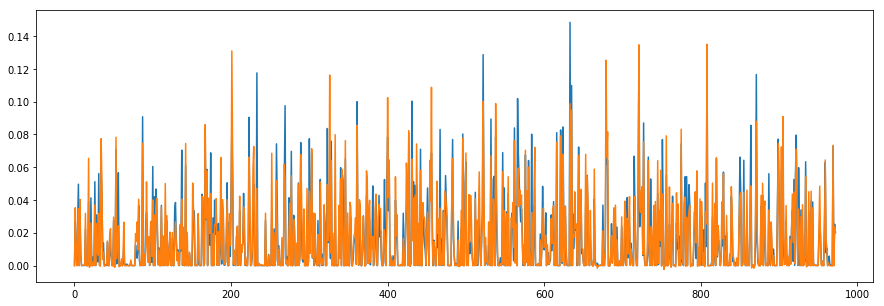

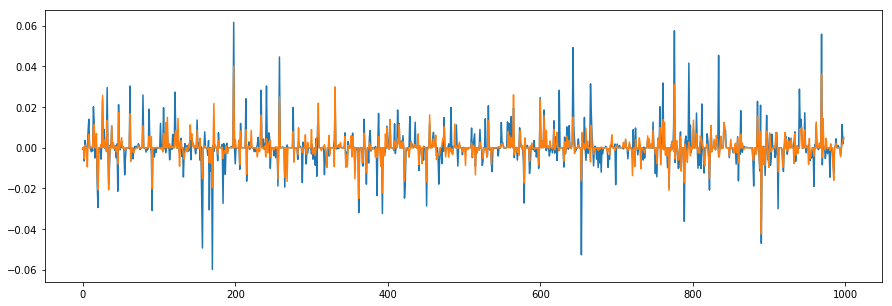

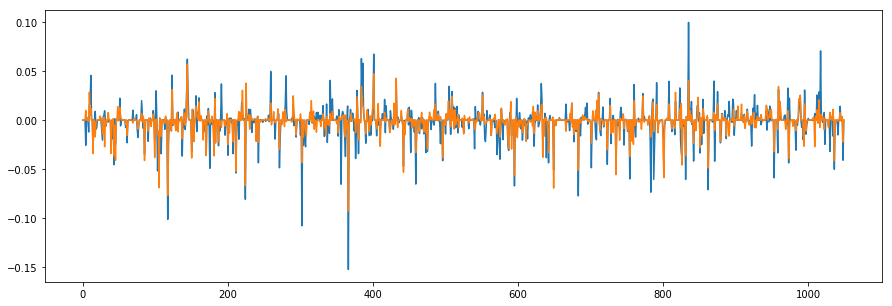

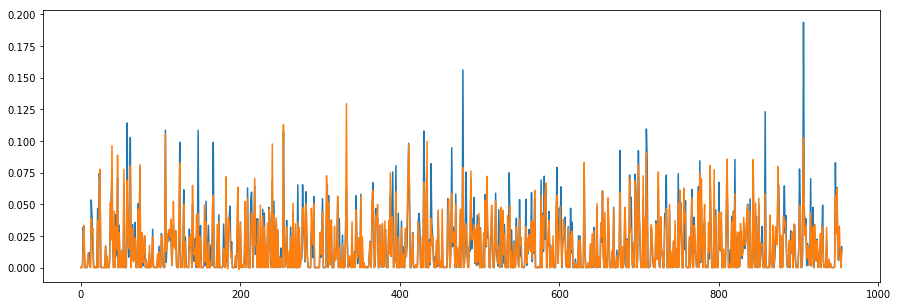

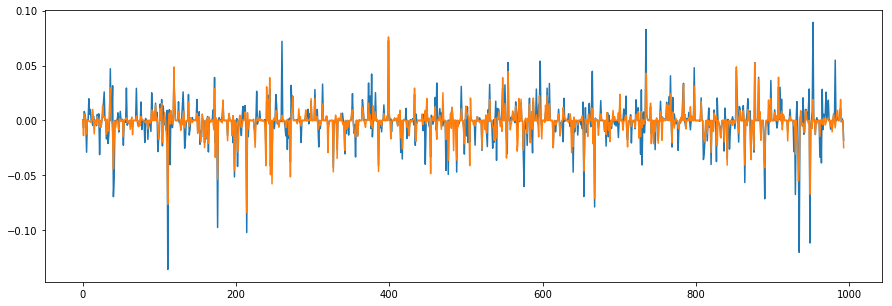

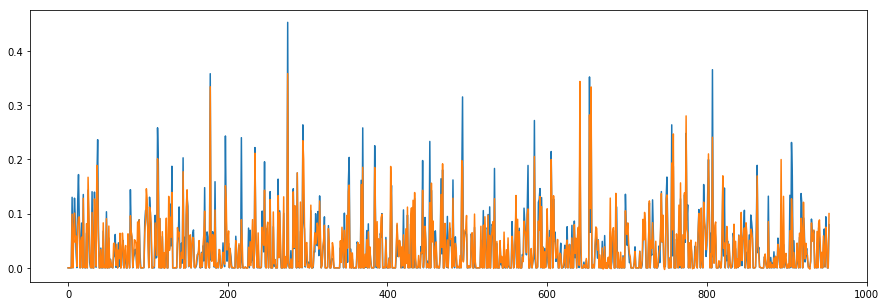

In [305]:
#model_nn_1, results_nn_1 = main('one-layer NN', 1)
#model_nn_2, results_nn_2 = main('two-layer NN', 1)
#model_conv_3d, results_conv_3d = main('conv-3d NN', 3)
model_conv_3d_aug, results_conv_3d_aug = main('conv-3d NN', 3, True)
#model_conv_3d_5, results_conv_3d_5 = main('conv-3d NN', 5)

In [239]:
results_nn_1

[(array([[1.        , 0.69128054],
         [0.69128054, 1.        ]]), 0.018301971244576203),
 (array([[1.       , 0.0523396],
         [0.0523396, 1.       ]]), 0.009273993939453452),
 (array([[1.        , 0.13948263],
         [0.13948263, 1.        ]]), 0.015934335479178743),
 (array([[1.        , 0.69427993],
         [0.69427993, 1.        ]]), 0.018161323284751216),
 (array([[1.       , 0.0815695],
         [0.0815695, 1.       ]]), 0.015933367740122904),
 (array([[1.        , 0.62905948],
         [0.62905948, 1.        ]]), 0.04198677745002861)]

In [240]:
results_nn_2

[(array([[1.        , 0.71140839],
         [0.71140839, 1.        ]]), 0.017790104799482145),
 (array([[1.        , 0.05785792],
         [0.05785792, 1.        ]]), 0.009250143810950129),
 (array([[1.        , 0.13780409],
         [0.13780409, 1.        ]]), 0.015928830981191005),
 (array([[1.        , 0.70551124],
         [0.70551124, 1.        ]]), 0.017896246930783382),
 (array([[1.        , 0.09160915],
         [0.09160915, 1.        ]]), 0.015886190142667525),
 (array([[1.        , 0.63255719],
         [0.63255719, 1.        ]]), 0.041851624938358985)]

In [241]:
results_conv_3d

[(array([[1.        , 0.90650221],
         [0.90650221, 1.        ]]), 0.010663141908193468),
 (array([[1.        , 0.76932786],
         [0.76932786, 1.        ]]), 0.006004731584325964),
 (array([[1.       , 0.8142811],
         [0.8142811, 1.       ]]), 0.009672868051615147),
 (array([[1.        , 0.91146716],
         [0.91146716, 1.        ]]), 0.010348182977120923),
 (array([[1.        , 0.82096789],
         [0.82096789, 1.        ]]), 0.009360621777568854),
 (array([[1.        , 0.91594809],
         [0.91594809, 1.        ]]), 0.022785622510792695)]

In [308]:
results_conv_3d_aug

[(array([[1.        , 0.90394564],
         [0.90394564, 1.        ]]), 0.010864501783043294),
 (array([[1.        , 0.71667899],
         [0.71667899, 1.        ]]), 0.006466098539118549),
 (array([[1.       , 0.7646532],
         [0.7646532, 1.       ]]), 0.010661368369499056),
 (array([[1.        , 0.90790986],
         [0.90790986, 1.        ]]), 0.010553375777565589),
 (array([[1.        , 0.76508753],
         [0.76508753, 1.        ]]), 0.010504392701508025),
 (array([[1.        , 0.91672931],
         [0.91672931, 1.        ]]), 0.021974495029472775)]

Shape of Output Files:
(146, 96, 75) (146, 96, 75) (146, 96, 75)
Shape of Input Files:
(146, 96, 75)
(146, 96, 75)
(array([ 1,  1,  1, ..., 72, 72, 72]), array([ 1,  1,  1, ..., 94, 94, 94]), array([ 1,  2,  3, ..., 71, 72, 73]))



(494064, 3, 3, 3, 5)





(494064, 3, 3, 3, 5)
X_train shape (988128, 3, 3, 3, 5)
tau_train shape (988128, 1)
988128 train samples
494064 test samples
(988128, 3, 3, 3, 5)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_30 (Conv3D)           (None, 1, 1, 1, 128)      17408     
_________________________________________________________________
activation_30 (Activation)   (None, 1, 1, 1, 128)      0         
_________________________________________________________________
flatten_30 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_247 (Dense)            (None, 16)                2064      
_

988128/988128 [==============================] - 609s 616us/step - loss: 0.7667 - mean_squared_error: 0.7667 - val_loss: 0.7575 - val_mean_squared_error: 0.7575
Epoch 14/20
988128/988128 [==============================] - 608s 615us/step - loss: 0.7624 - mean_squared_error: 0.7624 - val_loss: 0.7521 - val_mean_squared_error: 0.7521
Epoch 15/20
988128/988128 [==============================] - 608s 616us/step - loss: 0.7591 - mean_squared_error: 0.7591 - val_loss: 0.7436 - val_mean_squared_error: 0.7436
Epoch 16/20
988128/988128 [==============================] - 608s 615us/step - loss: 0.7565 - mean_squared_error: 0.7565 - val_loss: 0.7454 - val_mean_squared_error: 0.7454
Epoch 17/20
988128/988128 [==============================] - 607s 615us/step - loss: 0.7539 - mean_squared_error: 0.7539 - val_loss: 0.7538 - val_mean_squared_error: 0.7538
Epoch 18/20
988128/988128 [==============================] - 607s 615us/step - loss: 0.7514 - mean_squared_error: 0.7514 - val_loss: 0.7469 - val_m

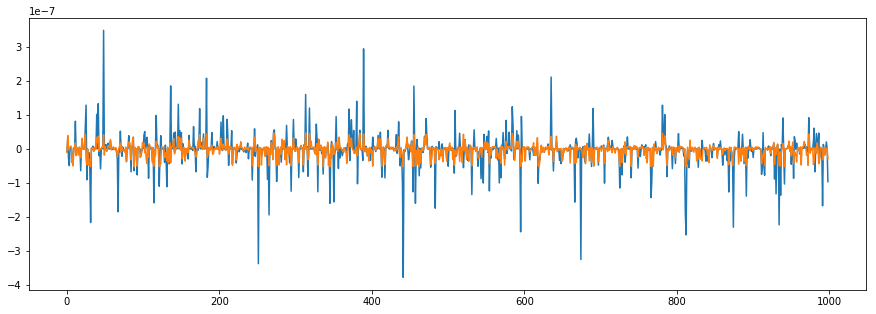

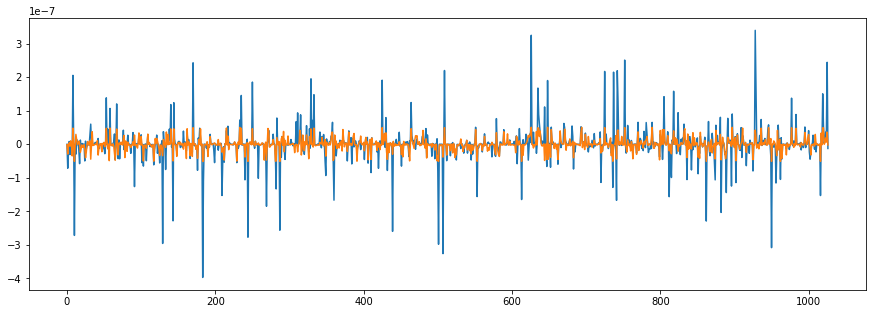

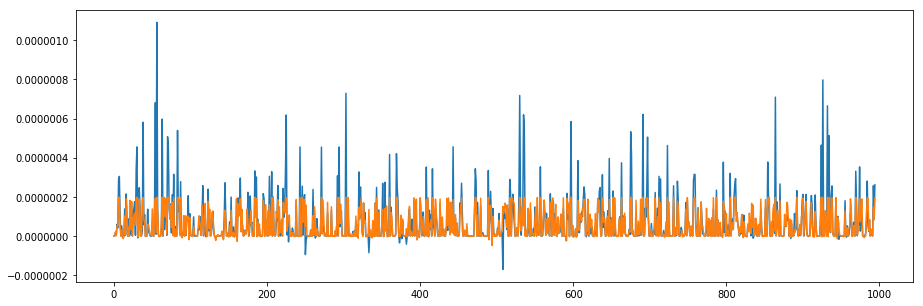

In [312]:
#model_nn_1_heat, results_nn_1_heat = main_heat('one-layer NN', 1)
#model_nn_2_heat, results_nn_2_heat = main_heat('two-layer NN', 1)
#model_conv_3d_heat, results_conv_3d_heat = main_heat('conv-3d NN', 3)
model_conv_3d_aug_heat, results_conv_3d_aug_heat = main_heat('conv-3d NN', 3, True)
#model_conv_3d_5_heat, results_conv_3d_5_heat = main_heat('conv-3d NN', 5)

In [242]:
results_nn_1_heat

[(array([[1.        , 0.22214517],
         [0.22214517, 1.        ]]), 5.423537704583692e-08),
 (array([[1.       , 0.1326358],
         [0.1326358, 1.       ]]), 5.4933549917546137e-08),
 (array([[1.        , 0.65760738],
         [0.65760738, 1.        ]]), 1.0036455536678398e-07)]

In [243]:
results_nn_2_heat

[(array([[1.        , 0.22925952],
         [0.22925952, 1.        ]]), 5.431780828535776e-08),
 (array([[1.        , 0.13592313],
         [0.13592313, 1.        ]]), 5.4546890420478587e-08),
 (array([[1.        , 0.66339873],
         [0.66339873, 1.        ]]), 1.0057676774645586e-07)]

In [245]:
results_conv_3d_heat

[(array([[1.        , 0.60753991],
         [0.60753991, 1.        ]]), 4.21258979259204e-08),
 (array([[1.       , 0.6133743],
         [0.6133743, 1.       ]]), 4.303750465959135e-08),
 (array([[1.        , 0.75129853],
         [0.75129853, 1.        ]]), 8.801370931803983e-08)]

In [313]:
results_conv_3d_aug_heat

[(array([[1.        , 0.57888657],
         [0.57888657, 1.        ]]), 4.3213801374589745e-08),
 (array([[1.        , 0.61041734],
         [0.61041734, 1.        ]]), 4.376780013615518e-08),
 (array([[1.        , 0.74994291],
         [0.74994291, 1.        ]]), 8.83082919938342e-08)]